In [51]:
import os
import sys
import pandas as pd
import datetime

import pathlib
import matplotlib.pyplot as plt
import numpy as np
import tensorflow as tf
import importlib


from tensorflow.keras import layers, losses
from tensorflow.keras.models import Model
from tensorflow import keras
from tensorflow.keras import callbacks  

# project specific
sys.path.append('../src')
from utils import data_handler
from utils import benchmark
from utils import visualisation
from utils.models import vanilla_autoencoder


import seaborn as sns
import matplotlib.pyplot as plt
from tensorflow.python.ops.numpy_ops import np_config
np_config.enable_numpy_behavior()

import plotly.express as px
import plotly.subplots as sp
import plotly.graph_objs as go

pd.options.display.width = 1000


# Silhouette score of original groups
from sklearn.metrics import silhouette_score
from utils.benchmark import dunn_index
from utils.benchmark import davies_bouldin

from sklearn.cluster import KMeans

import helpers


%load_ext tensorboard
!rm -rf ../workfiles/logs/

The tensorboard extension is already loaded. To reload it, use:
  %reload_ext tensorboard


## Experiment 

In [ ]:
suggested_genes_file_1 = '../../data/PD_genes_of_interest/signif_de_Disease_status_IDIOPATHIC_PD_01.tsv'
suggested_genes_file_2 = '../../data/PD_genes_of_interest/signif_de_PD_DIAGNOSIS_0.1.tsv'

In [52]:
# experiment 1
x_train, filenames, n_genes, gene_names = data_handler.generate_dataset_transcripts(
    feature_selection_threshold = 5, 
    gene_selection_file = None)

not applying any filtering over phases
retaining all patient who have at least passed the Base Line Visit...
loading samples...
loaded 4445 samples
selecting genes based on median absolute deviation threshold:  5 ...


In [ ]:
# experiment 2
x_train, filenames, n_genes, gene_names = data_handler.generate_dataset_transcripts(
    feature_selection_threshold = 0, 
    gene_selection_file = suggested_genes_file_1)

In [ ]:
# experiment 3
x_train, filenames, n_genes, gene_names = data_handler.generate_dataset_transcripts(
    feature_selection_threshold = 0, 
    gene_selection_file = suggested_genes_file_2)


## End of experiment selection

In [ ]:
importlib.reload(vanilla_autoencoder) # to allow modification of the script without restarting the whole session

latent_dim = 16

t_shape = (n_genes)


autoencoder = vanilla_autoencoder.generate_model(t_shape, latent_dim)
autoencoder.compile(optimizer='adam', loss=tf.keras.losses.MeanSquaredError())

In [ ]:
import visualkeras
visualkeras.layered_view(autoencoder).show()

In [34]:
checkpoint_filepath = '../workfiles/simple_ae/checkpoint'
model_checkpoint_callback = callbacks.ModelCheckpoint(
    filepath=checkpoint_filepath,
    save_weights_only=True,
    monitor='loss',
    mode='min',
    save_best_only=True)


reduce_lr = callbacks.ReduceLROnPlateau(monitor='loss', factor=0.2,
                              patience=20, min_lr=0.00001)

early_stopping_callback = callbacks.EarlyStopping(monitor='loss', patience=70)


log_dir = "../workfiles/logs/fit/" + datetime.datetime.now().strftime("%Y%m%d-%H%M%S")
tensorboard_callback = callbacks.TensorBoard(log_dir=log_dir, histogram_freq=1)

cb = [model_checkpoint_callback, reduce_lr, early_stopping_callback, tensorboard_callback]

In [35]:
hist = autoencoder.fit(x_train, epochs=500, callbacks=cb) 

Epoch 1/500


70/70 [==============================] - 8s 98ms/step - loss: 0.0224 - lr: 0.0010
Epoch 2/500
70/70 [==============================] - 7s 98ms/step - loss: 0.0153 - lr: 0.0010
Epoch 3/500
70/70 [==============================] - 7s 101ms/step - loss: 0.0163 - lr: 0.0010
Epoch 4/500
70/70 [==============================] - 6s 92ms/step - loss: 0.0150 - lr: 0.0010
Epoch 5/500
70/70 [==============================] - 6s 86ms/step - loss: 0.0164 - lr: 0.0010
Epoch 6/500
70/70 [==============================] - 6s 88ms/step - loss: 0.0149 - lr: 0.0010
Epoch 7/500
70/70 [==============================] - 7s 100ms/step - loss: 0.0149 - lr: 0.0010
Epoch 8/500
70/70 [==============================] - 6s 91ms/step - loss: 0.0148 - lr: 0.0010
Epoch 9/500
70/70 [==============================] - 6s 88ms/step - loss: 0.0146 - lr: 0.0010
Epoch 10/500
70/70 [==============================] - 7s 97ms/step - loss: 0.0142 - lr: 0.0010
Epoch 11/500
70/70 [==============================] - 6s 90ms/step - 

In [36]:
autoencoder.load_weights(checkpoint_filepath)


benchmarking model : vanilla_autoencoder
number of parametters of the model: 13434400
shape of the dataset: (4445, 5914)
the dataset meets the min_max requirement
loss: 0.0047910796
adding new performer to the history


model_name  param_count      loss  obs_count  gene_number
0        FC_autoencoder     50460224  0.008361       4445        23989
1        FC_autoencoder     50460224  0.008114       4445        23989
2   vanilla_autoencoder     19887680  0.019203       4445         9061
3   vanilla_autoencoder      5805632  0.002761       4445         2185
4   vanilla_autoencoder     13442624  0.004807       4445         5914
5   vanilla_autoencoder      5805632  0.003180       4445         2185
6   vanilla_autoencoder      8054336  0.009517       4445         3283
7   vanilla_autoencoder      5805632  0.002430       4445         2185
8   vanilla_autoencoder     13442624  0.004881       4445         5914
9   vanilla_autoencoder      5805632  0.003464       4445         2185
10  vanilla_autoencoder      8054336  0.009268       4445         3283
11  vanilla_autoencoder     13442624  0.005325       4445         5914
12  vanilla_autoencoder     13442624  0.005290       4445         5914
13  vanilla_autoencoder     13442624  0.016246       4445         5914
0   vanilla_autoencoder     13434400  0.004791       4445         5914

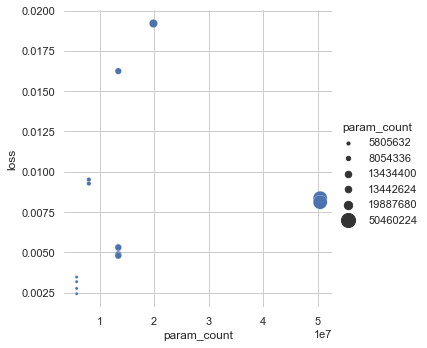

In [37]:
importlib.reload(benchmark) # to allow modification of the script without restarting the whole session
benchmark.benchmark(autoencoder, x_train)

[0.01765582524240017, 0.015390357933938503, 0.015799319371581078, 0.014894746243953705, 0.015933450311422348, 0.015297629870474339, 0.01480078510940075, 0.014651656150817871, 0.014364847913384438, 0.01418957021087408, 0.012803535908460617, 0.011625793762505054, 0.011208996176719666, 0.011068912222981453, 0.010912211611866951, 0.01083865575492382, 0.010785672813653946, 0.010751502588391304, 0.01070904079824686, 0.01064973697066307, 0.010599281638860703, 0.010628189891576767, 0.010502185672521591, 0.01041484996676445, 0.010257565416395664, 0.010344983078539371, 0.01011650636792183, 0.010283802635967731, 0.010036371648311615, 0.009839409962296486, 0.009634892456233501, 0.00958943273872137, 0.00950225256383419, 0.009525949135422707, 0.009434721432626247, 0.009386424906551838, 0.00929929781705141, 0.009275082498788834, 0.009297183714807034, 0.00917805079370737, 0.009143399074673653, 0.009026126004755497, 0.009012702852487564, 0.008860219269990921, 0.008763390593230724, 0.00871807150542736, 

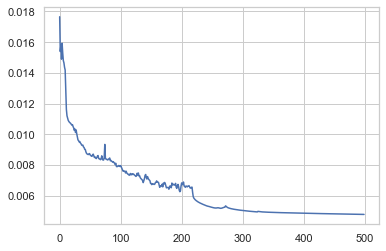

In [38]:
plt.plot(hist.history['loss'])
print(hist.history['loss'])

### some diagnosis

In [39]:
importlib.reload(visualisation) # to allow modification of the script without restarting the whole session
visualisation.plot_single_obs_processing(x_train, autoencoder)

In [40]:
compressed_dataframe = autoencoder.encoder.predict(x_train)

70/70 [==============================] - 1s 7ms/step


In [41]:
df = pd.DataFrame(compressed_dataframe)
df["name"] = filenames

139/139 [==============================] - 1s 4ms/step


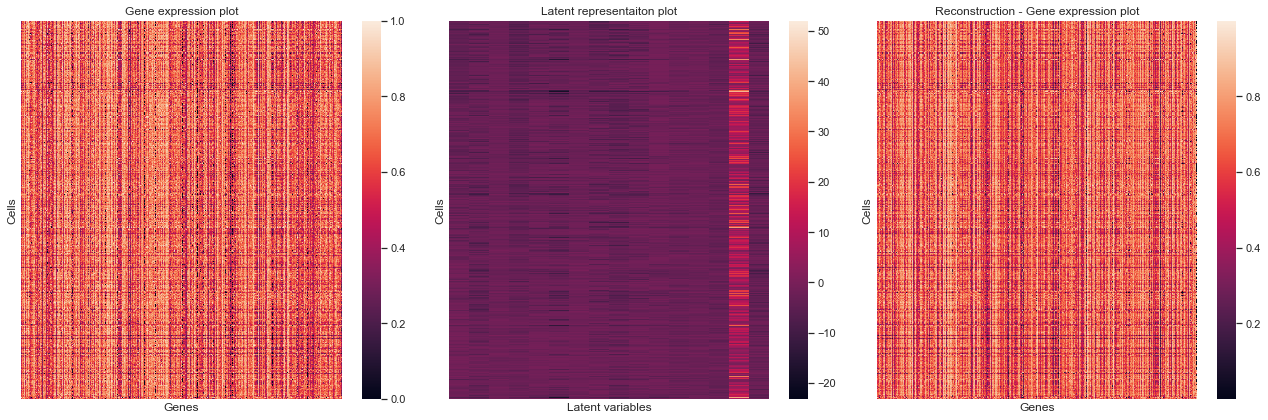

In [42]:
importlib.reload(visualisation) # to allow modification of the script without restarting the whole session
visualisation.plot_dataset_processing(x_train, autoencoder)

In [43]:
metadata_path = "../../METADATA_200123.xlsx"

meta_data = pd.read_excel(metadata_path, header = 1, usecols = range(1,10) )
patient_ids = [int(name.split(".")[1]) for name in filenames]

# Create a dictionary to map 'Patient Number' to 'Disease Status'
patient_disease_status = dict(zip(meta_data['Patient Number'], meta_data['Disease Status']))

label = [patient_disease_status.get(patient_id, None) for patient_id in patient_ids]
label = pd.Series(label)
num_classes = len(pd.Series(label).unique())

## First, Analyse All groups

######################## OG Groups : 


/opt/homebrew/anaconda3/envs/thesis/lib/python3.9/site-packages/sklearn/manifold/_t_sne.py:780: FutureWarning:

The default initialization in TSNE will change from 'random' to 'pca' in 1.2.

/Users/aygalic/Thesis/genome_analysis_parkinson/thesis_related/../src/utils/visualisation.py:204: UserWarning:

No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored



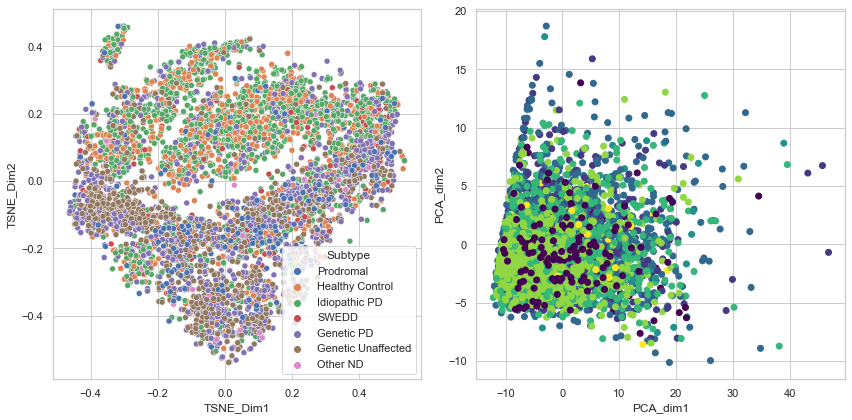

Silhouette Score: -0.0484
Dunn Index: 0.2446
Davies-Bouldin Index: 12.8417
######################## KNMEANS : 


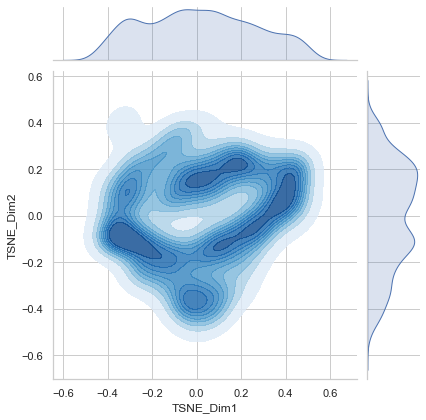

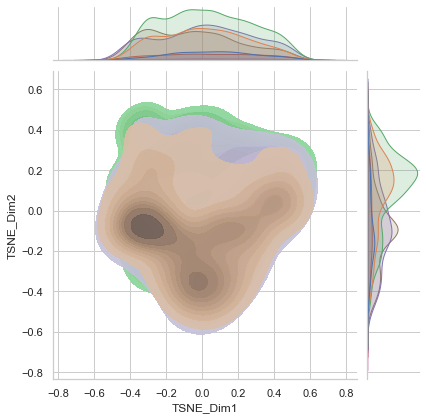

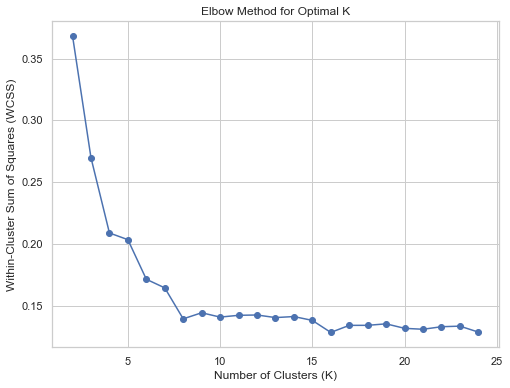

/opt/homebrew/anaconda3/envs/thesis/lib/python3.9/site-packages/sklearn/manifold/_t_sne.py:780: FutureWarning:

The default initialization in TSNE will change from 'random' to 'pca' in 1.2.

/Users/aygalic/Thesis/genome_analysis_parkinson/thesis_related/../src/utils/visualisation.py:204: UserWarning:

No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored



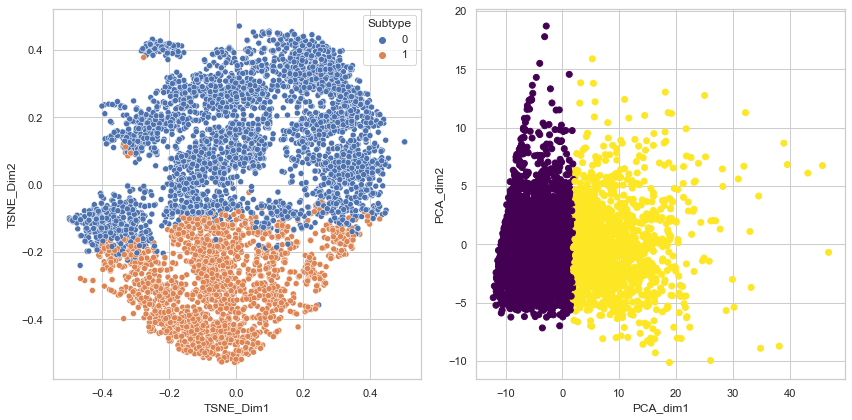

Silhouette Score: 0.3683
Dunn Index: 1.0000
Davies-Bouldin Index: 1.0675


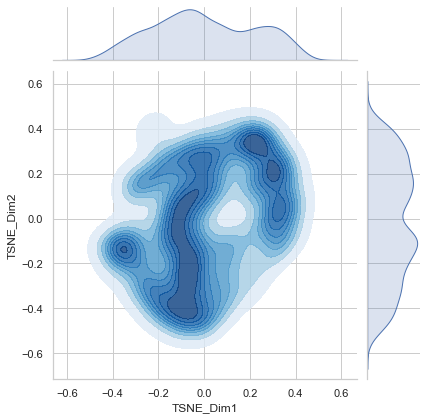

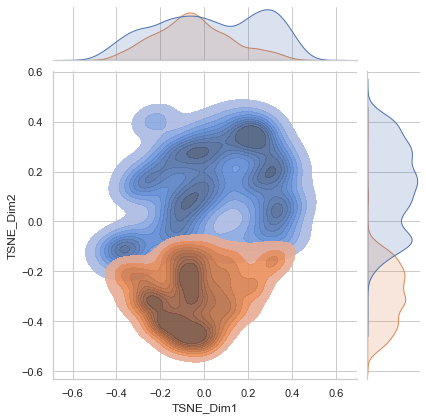

In [44]:
importlib.reload(visualisation)
importlib.reload(helpers)

print("######################## OG Groups : ")
TSNE_params = {
            "early_exaggeration" : 50,
            "learning_rate" : 500, 
            #"perplexity" : 75, 
            "perplexity" : 100, 
            "min_grad_norm" : 1e-7, 
            "n_iter" : 2000,
            "n_components" : 2
        }
visualisation.plot_clusters(compressed_dataframe, label, TSNE_params)
benchmark.print_metrics(compressed_dataframe, label)

print("######################## KNMEANS : ")
kmeans_labels = helpers.auto_kMean(compressed_dataframe)
visualisation.plot_clusters(compressed_dataframe, kmeans_labels, TSNE_params)
benchmark.print_metrics(compressed_dataframe, kmeans_labels)



## Second, Check if control group leads to any clusters 

In [45]:
# filtering data
clinical_info_series = pd.Series(label)
filenames_series = pd.Series(filenames)

# Create boolean masks for filtering
clinical_mask = clinical_info_series == "Healthy Control"


# Apply the mask to your dataset
filtered_dat = compressed_dataframe[clinical_mask]
filtered_clinical_info = clinical_info_series[clinical_mask]

# Check the shape of the filtered dataset
print(filtered_dat.shape)
print(filtered_clinical_info.shape)

(820, 16)
(820,)


######################## OG Groups : 


/opt/homebrew/anaconda3/envs/thesis/lib/python3.9/site-packages/sklearn/manifold/_t_sne.py:780: FutureWarning:

The default initialization in TSNE will change from 'random' to 'pca' in 1.2.

/Users/aygalic/Thesis/genome_analysis_parkinson/thesis_related/../src/utils/visualisation.py:204: UserWarning:

No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored



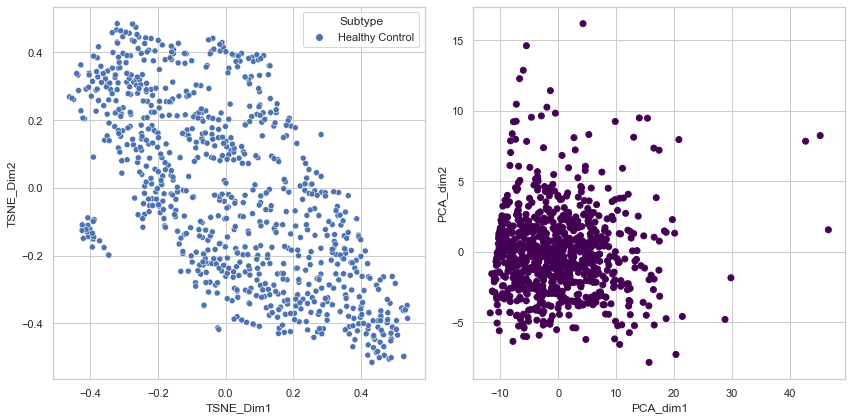

######################## KNMEANS : 


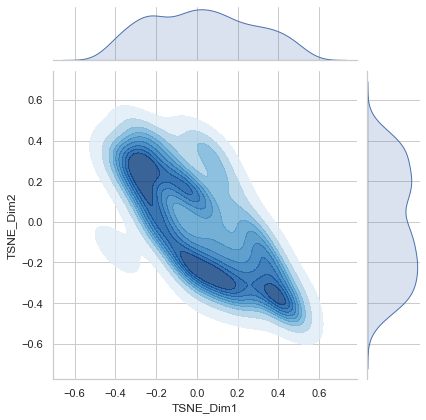

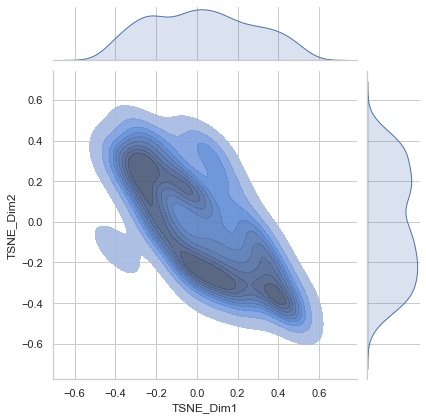

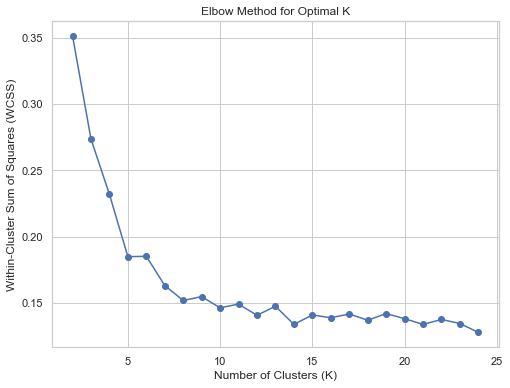

/opt/homebrew/anaconda3/envs/thesis/lib/python3.9/site-packages/sklearn/manifold/_t_sne.py:780: FutureWarning:

The default initialization in TSNE will change from 'random' to 'pca' in 1.2.

/Users/aygalic/Thesis/genome_analysis_parkinson/thesis_related/../src/utils/visualisation.py:204: UserWarning:

No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored



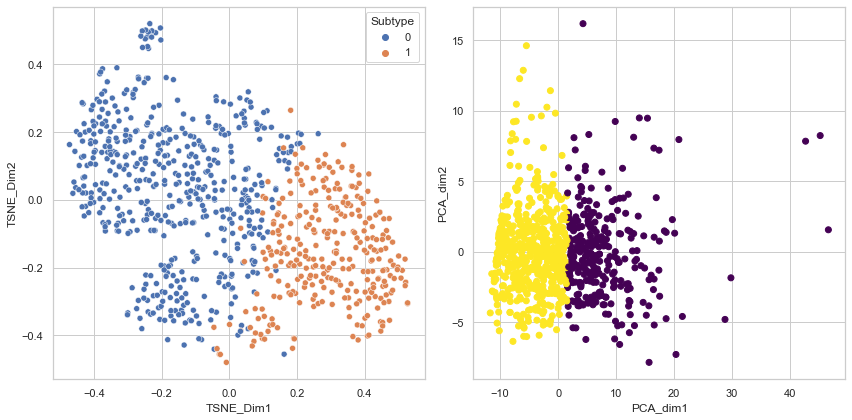

Silhouette Score: 0.3513
Dunn Index: 1.0000
Davies-Bouldin Index: 1.0926


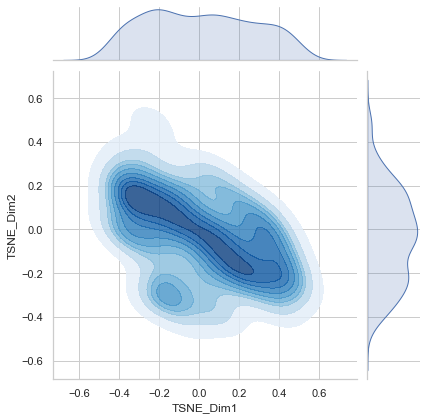

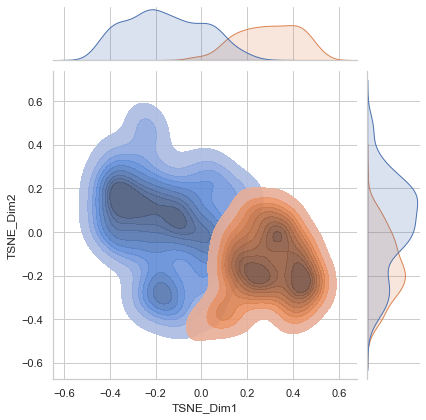

In [46]:
importlib.reload(visualisation)
importlib.reload(helpers)

print("######################## OG Groups : ")
TSNE_params = {
            "early_exaggeration" : 50,
            "learning_rate" : 500, 
            "perplexity" : 50, 
            "min_grad_norm" : 1e-7, 
            "n_iter" : 2000,
            "n_components" : 2
        }
visualisation.plot_clusters(filtered_dat, filtered_clinical_info, TSNE_params)

print("######################## KNMEANS : ")
kmeans_labels = helpers.auto_kMean(filtered_dat)
visualisation.plot_clusters(filtered_dat, kmeans_labels, TSNE_params)
benchmark.print_metrics(filtered_dat, kmeans_labels)




## Third : check for clusters in the Idiopathic PD group

In [47]:
# filtering data
# Convert clinical_info and filenames to Series for easy filtering
clinical_info_series = pd.Series(label)
filenames_series = pd.Series(filenames)

# Create boolean masks for filtering
clinical_mask = clinical_info_series == "Idiopathic PD"


# Apply the mask to your dataset
filtered_dat = compressed_dataframe[clinical_mask]
filtered_clinical_info = clinical_info_series[clinical_mask]

# Check the shape of the filtered dataset
print(filtered_dat.shape)
print(filtered_clinical_info.shape)

(1400, 16)
(1400,)


######################## OG Groups : 


/opt/homebrew/anaconda3/envs/thesis/lib/python3.9/site-packages/sklearn/manifold/_t_sne.py:780: FutureWarning:

The default initialization in TSNE will change from 'random' to 'pca' in 1.2.

/Users/aygalic/Thesis/genome_analysis_parkinson/thesis_related/../src/utils/visualisation.py:204: UserWarning:

No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored



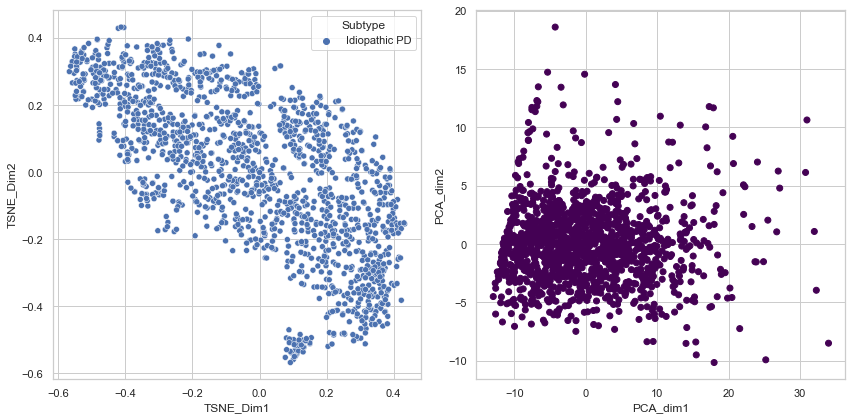

######################## KNMEANS : 


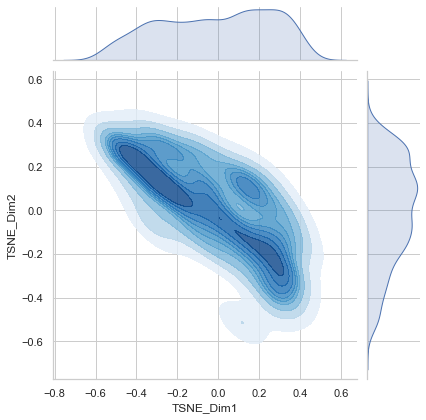

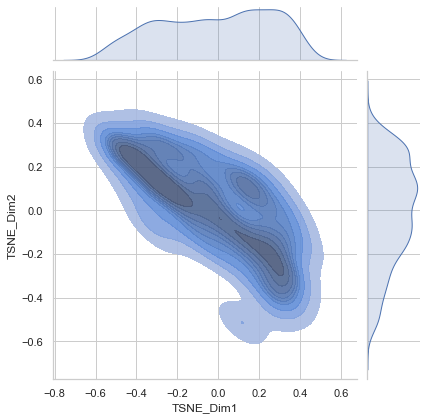

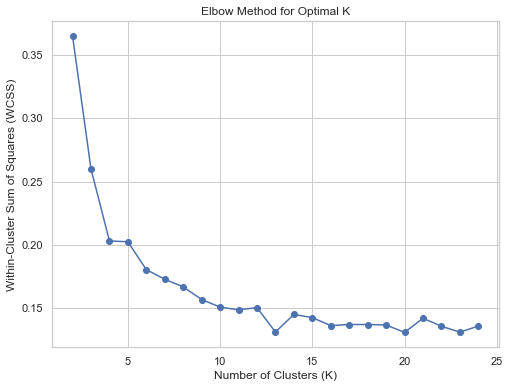

/opt/homebrew/anaconda3/envs/thesis/lib/python3.9/site-packages/sklearn/manifold/_t_sne.py:780: FutureWarning:

The default initialization in TSNE will change from 'random' to 'pca' in 1.2.

/Users/aygalic/Thesis/genome_analysis_parkinson/thesis_related/../src/utils/visualisation.py:204: UserWarning:

No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored



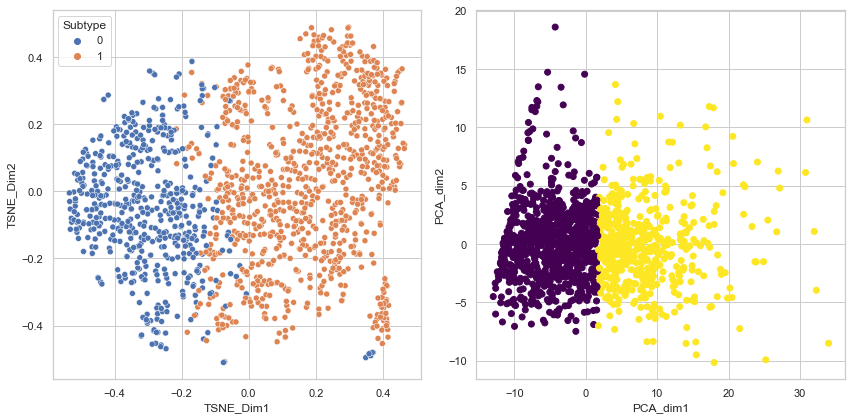

Silhouette Score: 0.3651
Dunn Index: 1.0000
Davies-Bouldin Index: 1.0579


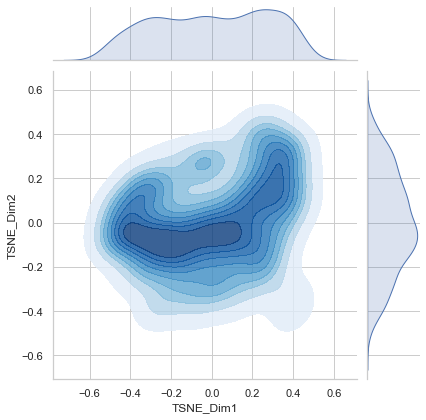

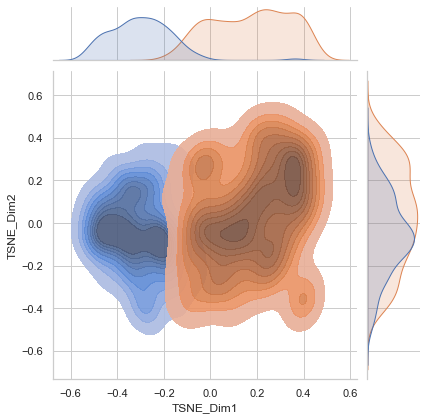

In [48]:
importlib.reload(visualisation)
importlib.reload(helpers)

print("######################## OG Groups : ")
params = {"early_exaggeration":10,
              "learning_rate":700, 
              "perplexity":15, 
              "min_grad_norm":1e-7, 
              "n_iter":1000,
              "n_components":2}
visualisation.plot_clusters(filtered_dat, filtered_clinical_info, TSNE_params)

print("######################## KNMEANS : ")
kmeans_labels = helpers.auto_kMean(filtered_dat)
visualisation.plot_clusters(filtered_dat, kmeans_labels, TSNE_params)
benchmark.print_metrics(filtered_dat, kmeans_labels)

## Last : Check for Genetic PD groups

In [49]:
# filtering data
# Convert clinical_info and filenames to Series for easy filtering
clinical_info_series = pd.Series(label)
filenames_series = pd.Series(filenames)

# Create boolean masks for filtering
clinical_mask = clinical_info_series == "Genetic PD"


# Apply the mask to your dataset
filtered_dat = compressed_dataframe[clinical_mask]
filtered_clinical_info = clinical_info_series[clinical_mask]

# Check the shape of the filtered dataset
print(filtered_dat.shape)
print(filtered_clinical_info.shape)

(944, 16)
(944,)


######################## OG Groups : 


/opt/homebrew/anaconda3/envs/thesis/lib/python3.9/site-packages/sklearn/manifold/_t_sne.py:780: FutureWarning:

The default initialization in TSNE will change from 'random' to 'pca' in 1.2.

/Users/aygalic/Thesis/genome_analysis_parkinson/thesis_related/../src/utils/visualisation.py:204: UserWarning:

No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored



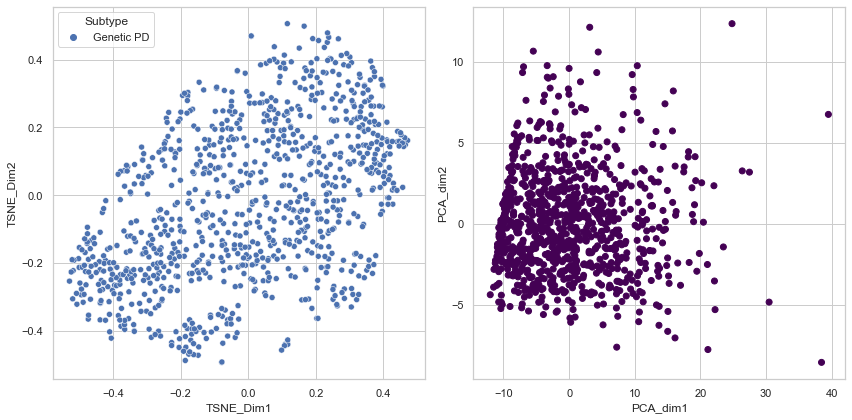

######################## KNMEANS : 


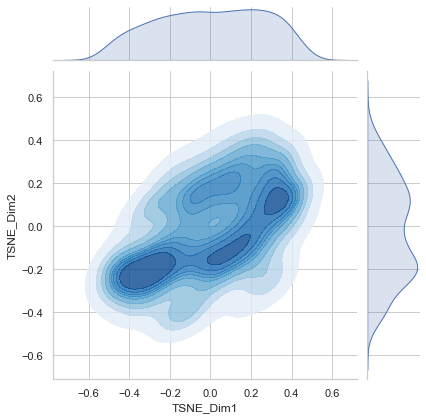

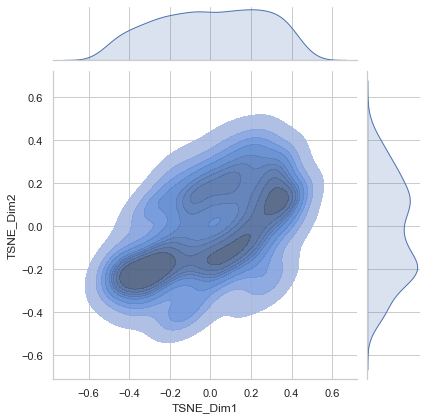

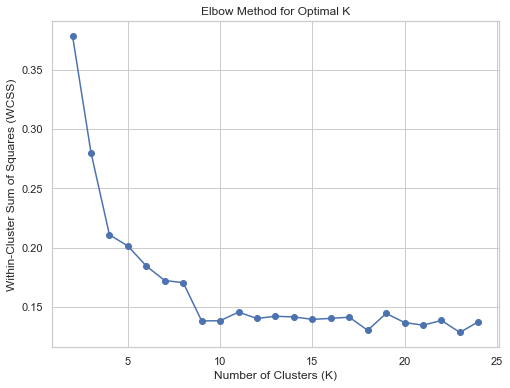

/opt/homebrew/anaconda3/envs/thesis/lib/python3.9/site-packages/sklearn/manifold/_t_sne.py:780: FutureWarning:

The default initialization in TSNE will change from 'random' to 'pca' in 1.2.

/Users/aygalic/Thesis/genome_analysis_parkinson/thesis_related/../src/utils/visualisation.py:204: UserWarning:

No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored



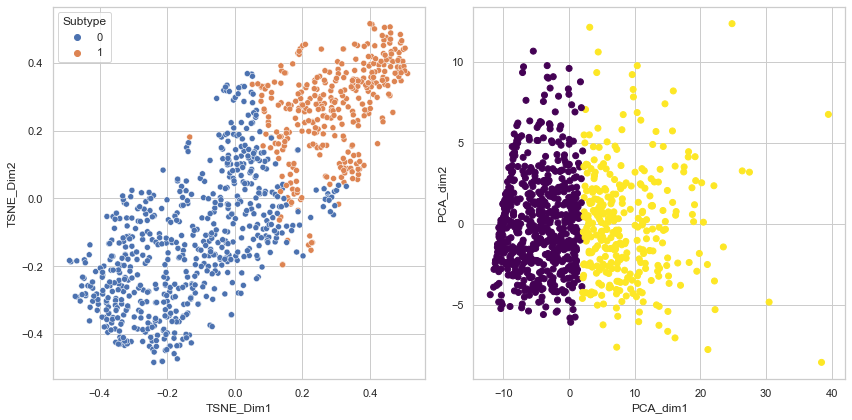

Silhouette Score: 0.3783
Dunn Index: 1.0000
Davies-Bouldin Index: 1.0446


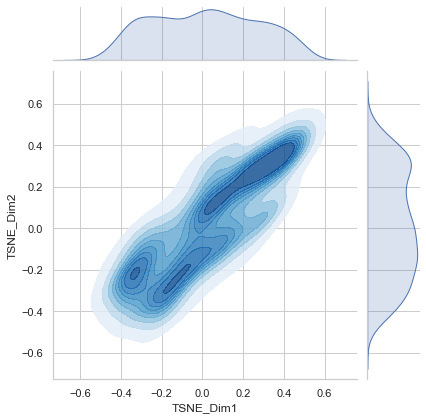

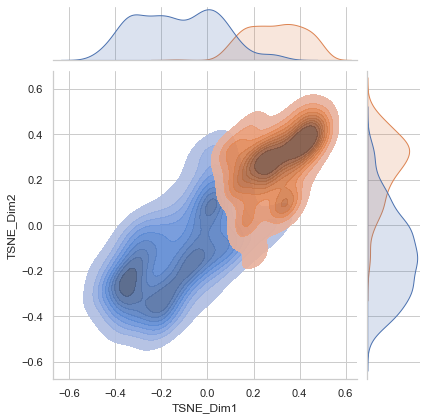

In [50]:
importlib.reload(visualisation)
importlib.reload(helpers)

print("######################## OG Groups : ")
params = {"early_exaggeration":5,
              "learning_rate":100, 
              "perplexity":30, 
              "min_grad_norm":1e-7, 
              "n_iter":5000,
              "n_components":2}
visualisation.plot_clusters(filtered_dat, filtered_clinical_info, TSNE_params)


print("######################## KNMEANS : ")
kmeans_labels = helpers.auto_kMean(filtered_dat)
visualisation.plot_clusters(filtered_dat, kmeans_labels, TSNE_params)
benchmark.print_metrics(filtered_dat, kmeans_labels)